In [1]:
import yaml
import praw

In [2]:
with open('backup/reddit-api-data.yml', 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [3]:
reddit = praw.Reddit(
    user_agent="Comment Extraction (by u/USERNAME)",
    client_id=config['id'],
    client_secret=config['secret'],
    username=config['username'],
    password=config['password'],
)

https://praw.readthedocs.io/en/latest/code_overview/models/comment.html#praw.models.Comment

In [4]:
import pandas as pd

def get_comments(post_id, top=False):
    submission = reddit.submission(id=post_id)
    comments_data = []
    
    submission.comments.replace_more(limit=None)
    sub = submission.comments if top else submission.comments.list()
    for comment in sub:
        data = [pd.to_datetime(comment.created_utc, unit='s'), comment.author, comment.body, comment.score]
        if top:
            data.append(len(comment.replies))
            data.append(len(comment.replies.list()))
        comments_data.append(data)
    
    if top:
        comments_df = pd.DataFrame(comments_data, columns=['date', 'author', 'body', 'score', 'replies', 'comms'])
    else:
        comments_df = pd.DataFrame(comments_data, columns=['date', 'author', 'body', 'score'])
    
    return comments_df.set_index('date').sort_index()

In [5]:
df = pd.read_csv("data/wsb_processed.csv", index_col=0)

In [6]:
def get_posts(df, n=100, top=False):
    posts = df[df['comms_num'] < 1000].sort_values('comms_num', ascending=False).head(n)
    plist = []
    for i in posts.index:
        plist.append(get_comments(i, top))
        
    return plist

In [7]:
posts = get_posts(df, 10, False)

In [8]:
posts[0].head()

,author,body,score
date,,,
2021-01-28 19:43:47,BONUS_PATER_FAMILIAS,ok boomer\n\n\n💎💎💎💎💎💎🙏🏻,4142
2021-01-28 19:43:53,Derp_State_Agent,"Fuckin boomers, man.",977
2021-01-28 19:43:56,Steevuhoh,\-insert surprised pikachu face- the boomers a...,863
2021-01-28 19:44:04,CPM17,More accurate than I expected it to be lol,5868
2021-01-28 19:44:05,Andreaspetersen12,Are they wrong?,0


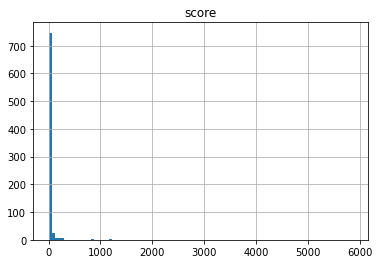

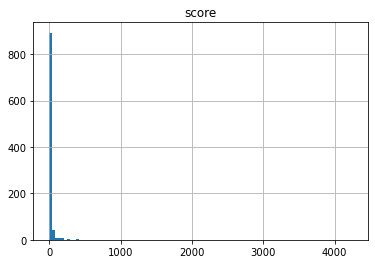

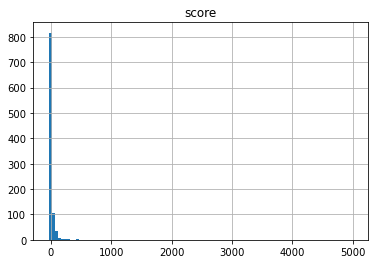

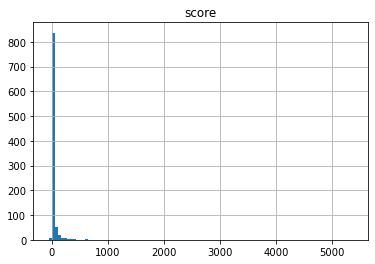

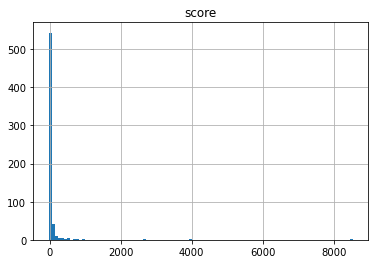

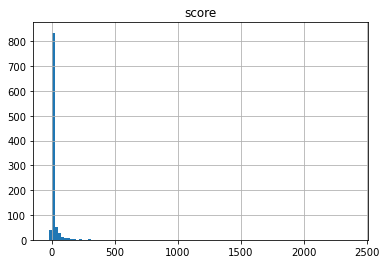

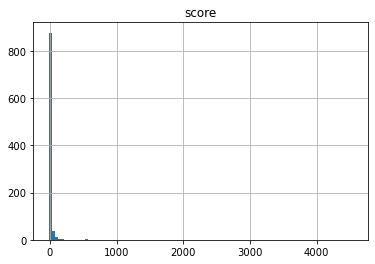

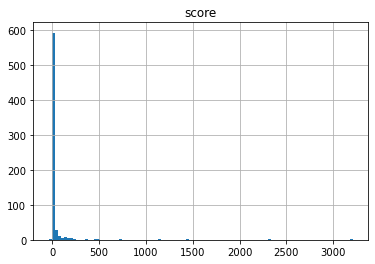

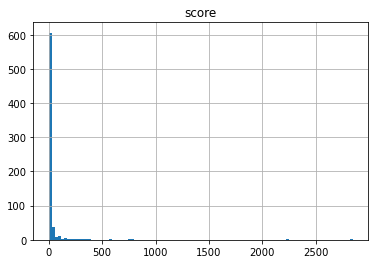

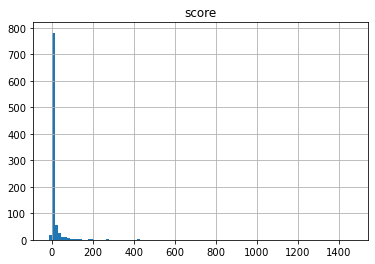

In [9]:
for post in posts:
    post.hist(bins=100)

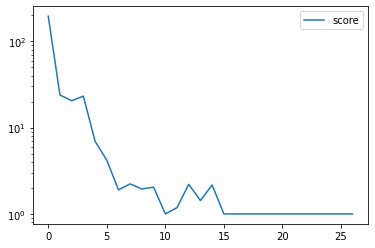

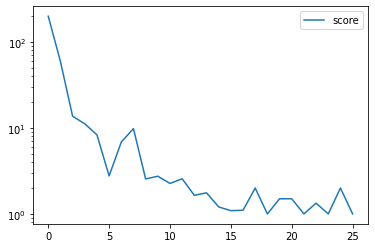

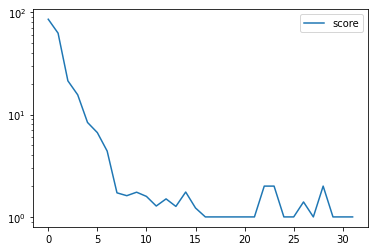

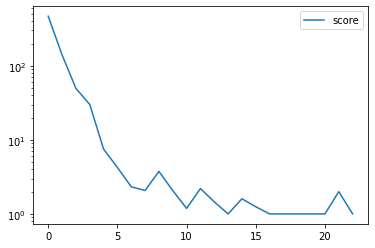

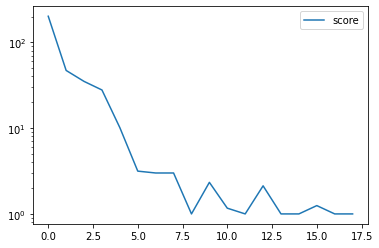

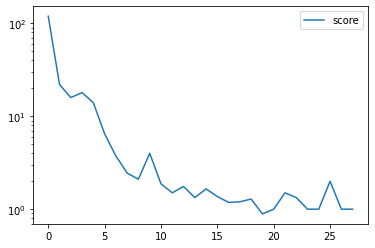

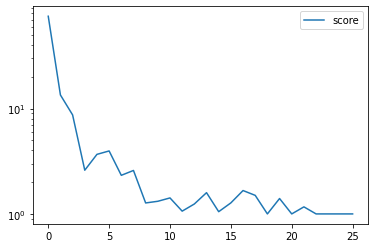

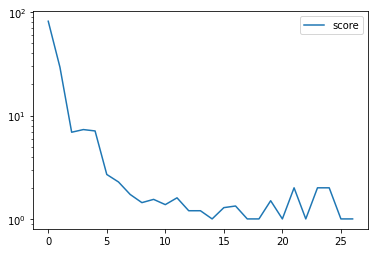

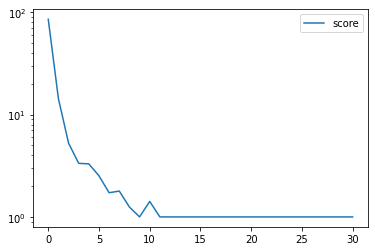

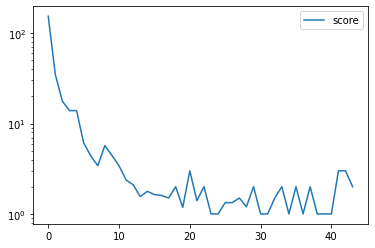

In [15]:
import matplotlib.pyplot as plt

for post in posts:
    post.groupby(lambda x: (x.month, x.day, x.hour)).mean().reset_index().plot()
    plt.yscale('log')

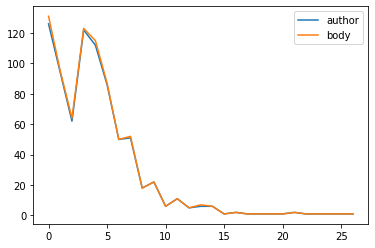

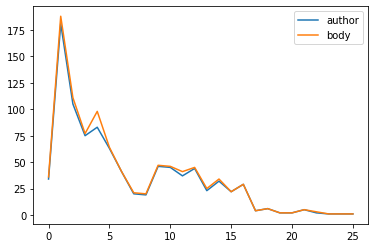

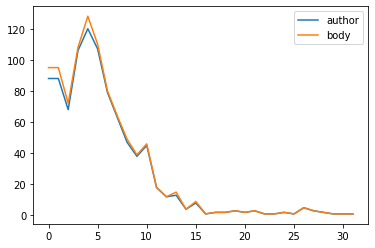

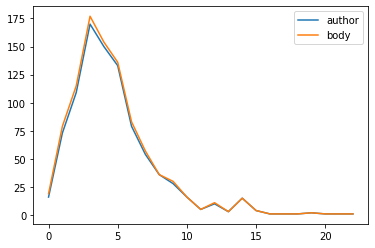

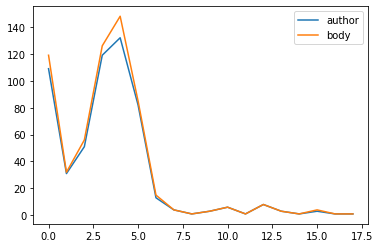

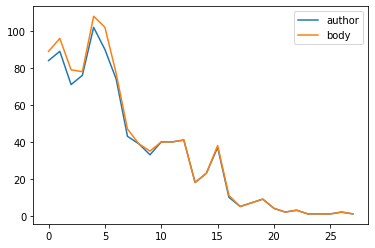

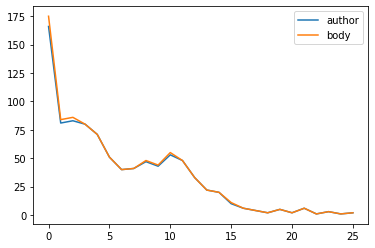

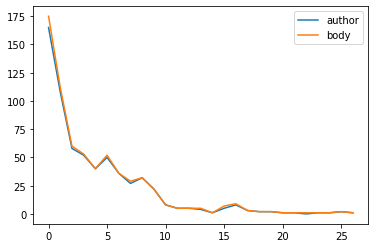

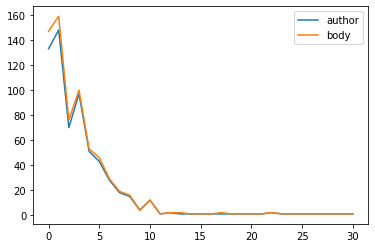

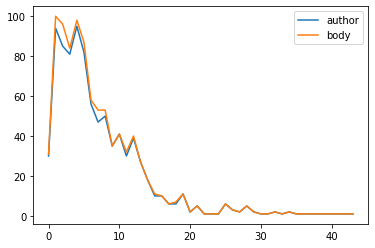

In [18]:
for post in posts:
    post[['author', 'body']].groupby(lambda x: (x.month, x.day, x.hour)).count().reset_index().plot()

In [19]:
tops = get_posts(df, 10, True)

In [20]:
tops[0].head()

,author,body,score,replies,comms
date,,,,,
2021-01-28 19:43:47,BONUS_PATER_FAMILIAS,ok boomer\n\n\n💎💎💎💎💎💎🙏🏻,4147,5,110
2021-01-28 19:43:53,Derp_State_Agent,"Fuckin boomers, man.",973,5,9
2021-01-28 19:43:56,Steevuhoh,\-insert surprised pikachu face- the boomers a...,870,4,5
2021-01-28 19:44:04,CPM17,More accurate than I expected it to be lol,5863,20,97
2021-01-28 19:44:05,Andreaspetersen12,Are they wrong?,-1,0,0


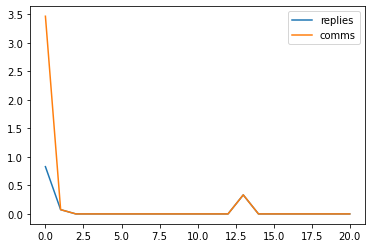

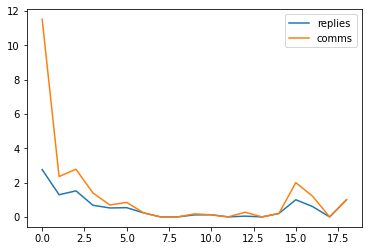

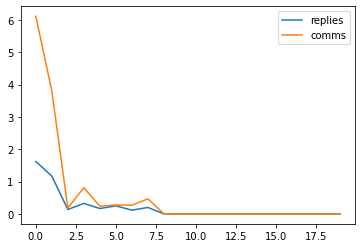

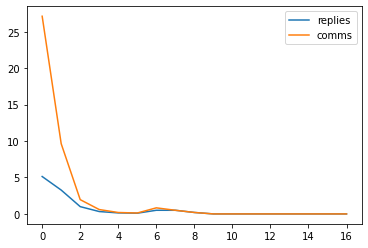

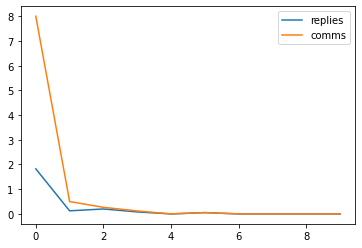

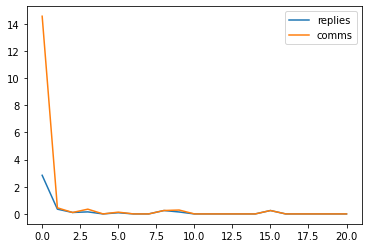

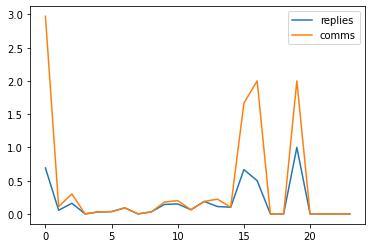

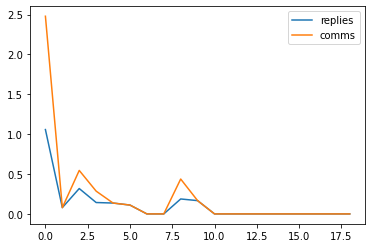

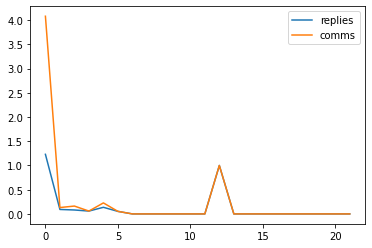

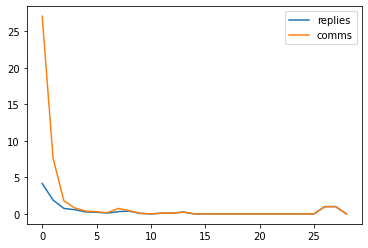

In [24]:
for top in tops:
    top[['replies', 'comms']].groupby(lambda x: (x.month, x.day, x.hour)).mean().reset_index().plot()

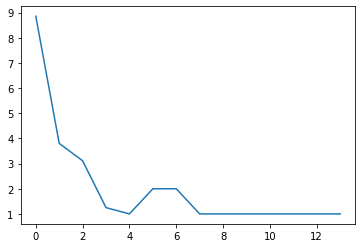

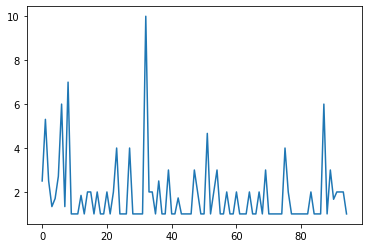

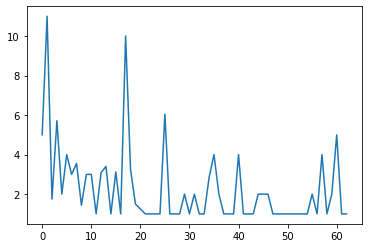

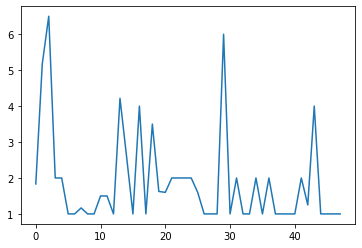

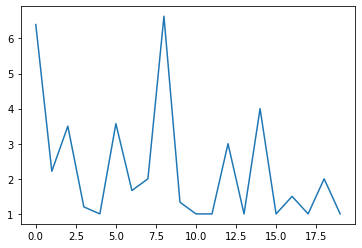

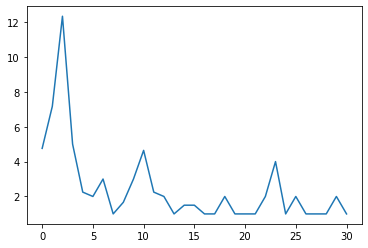

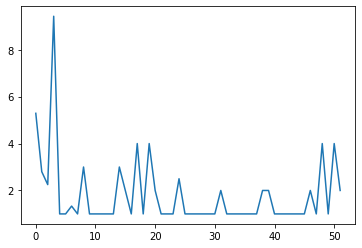

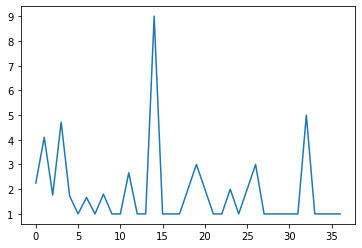

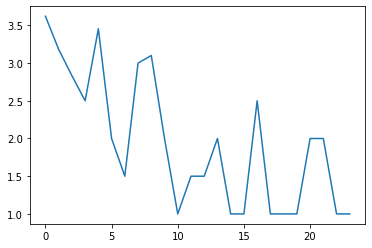

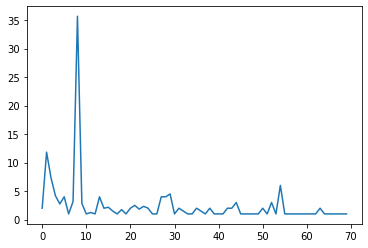

In [32]:
import matplotlib.pyplot as plt

for top in tops:
    means = top[top['replies'] > 0][['replies', 'comms']].groupby(lambda x: (x.month, x.day, x.hour, x.minute)).mean().reset_index()
    res = means['comms'] / means['replies']
    plt.figure()
    res.plot()

In [28]:
import spacy
import re
import emoji

nlp = spacy.load("en_core_web_sm")
EMOJIS = r"(\:[^ ][a-zA-Z0-9\s\_]*\:)"


def lemmatization(x):
    if type(x) == spacy.tokens.doc.Doc:
        return [token.lemma_ for token in x if not token.is_stop and token.is_alpha]
    return x

def type_check(x):
    return type(x) == spacy.tokens.doc.Doc

def get_punct(x):
    if type_check(x):
        for token in x:
            if token.pos_ == 'PUNCT':
                return 1
    return 0

def get_caps(x):
    if type_check(x):
        caps_perc = 0
        title_len = 0
        for token in x:
            title_len += len(token.shape_)
            caps_perc += token.shape_.count('X')
        return caps_perc / title_len
    return 0.0

def get_urls(x):
    if type_check(x):
        urls = 0
        for token in x:
            if 'https' in str(token):
                urls += 1
        return urls
    return 0

def get_emojis(x):
    res = re.findall(EMOJIS, x)
    return res

def decode_emojis(x):
    decoded = emoji.demojize(str(x))
    decoded = decoded.replace('::', ' ')
    emojis = get_emojis(decoded)
    
    emoji_list = []
    for emo in emojis:
        emo = emo.replace(':', '')
        emo = emo.split(" ")
        
        if type(emo) == list:
            emoji_list.extend(emo)
        else:
            emoji_list.append(emo)
        
    return emoji_list

def get_features(df):
    df = df.copy()
    df['body'] = df['body'].apply(lambda x: nlp(x) if type(x) == str else x)
    df['body_raw'] = df['body']
    df['body'] = df['body'].apply(lemmatization)
    df['body_length'] = df['body_raw'].apply(lambda x: len(x))
    df['body_urls'] = df['body_raw'].apply(get_urls)
    df['body_punct'] = df['body_raw'].apply(get_punct)
    df['body_emojis'] = df['body_raw'].apply(decode_emojis)
    df['body'] += df['body_emojis']
    df.drop(['body_emojis', 'body_raw'], axis=1, inplace=True)
    return df

def get_length(df):
    df = df.copy()
    df['body'] = df['body'].apply(lambda x: nlp(x) if type(x) == str else x)
    df['body_length'] = df['body'].apply(lambda x: len(x))
    return df

In [29]:
bow = get_features(posts[0])

In [30]:
bow.describe()

,score,body_length,body_urls,body_punct
count,806.000000,806.000000,806.000000,806.000000
mean,41.673697,15.730769,0.011166,0.722084
std,310.558229,17.509486,0.105144,0.448250
min,-1.000000,1.000000,0.000000,0.000000
25%,1.000000,6.000000,0.000000,0.000000
50%,1.000000,11.000000,0.000000,1.000000
75%,3.000000,19.000000,0.000000,1.000000
max,5868.000000,201.000000,1.000000,1.000000


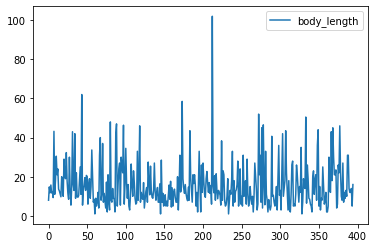

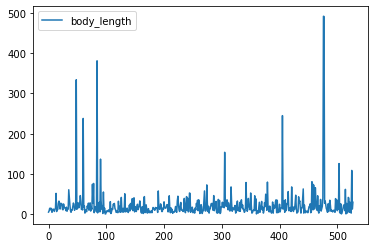

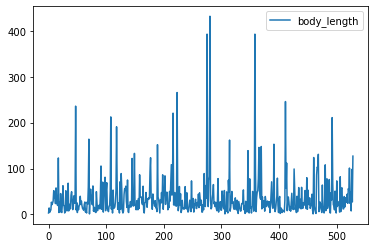

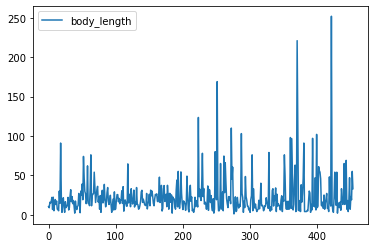

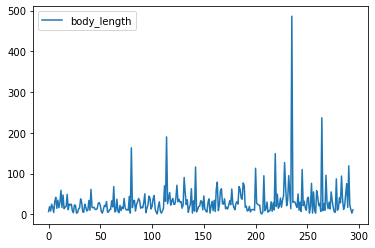

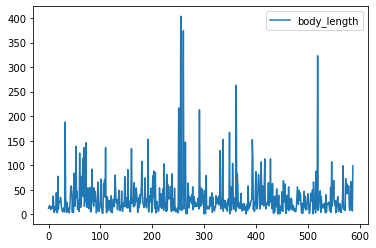

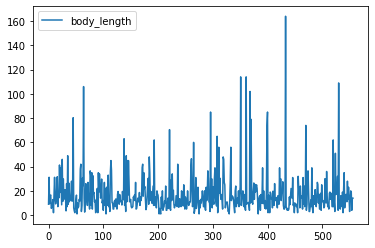

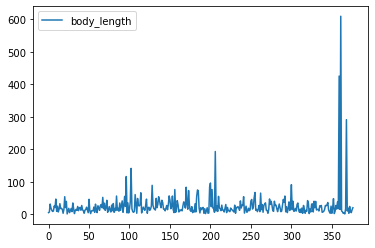

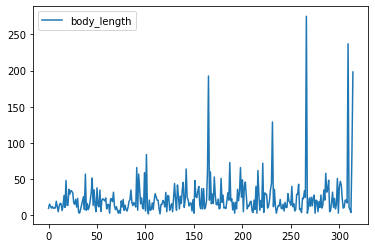

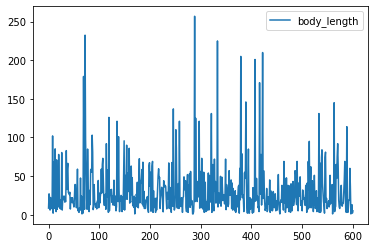

In [31]:
for post in posts:
    bow = get_length(post)
    bow.groupby(lambda x: (x.month, x.day, x.hour, x.minute)).mean()['body_length'].reset_index().plot()